# Interrogate crop poylgon to explore phenology

**What does this notebook do?**
This notebook allows the user to interrogate a pre-defined polygon, to explore crop phenology. 

This notebook plots up a polygon and GeoTiff for a region, and asks the user to select a polygon for interrogation. This polygon is then used to perform a datacube extraction for a defined time period. The user is able to choose between two analyses:
- NBAR
- Fractional Cover

**NBAR**
The extraction pulls in NBAR data for all available sensors (LS5, LS7, LS8, S2a, S2b). All sensors are not available at all time periods, and so the code is designed to allow sensors to be included and excluded, depending on the data availability over the period of interest. 

**Fractional Cover**
The extraction queries the fractional cover product, returning results for bare soil, green vegetation and non-green vegetation components. 

Once the extraction has been completed, the chosen polygon is then used to mask the data to remove pixels outside of the polygon. A polygon average and standard deviation is then calculated for each variable (sensor, or fractional cover component). 

Finally, a plot is produced to demonstrate the polygon variability over the chosen time period.

**Required inputs** A shape file containing the polygon you would like to use for the analysis. The path to this shapefile is set by the `shape_file` variable. Additionally, a geotiff is also loaded in that corresponds to the same shapefile, providing a background image for context. This image location is set using the `MaxNDVIFile` variable. 

Here, we use an NDVI GeoTiff, and the subsequent image segmented shapefile for the analysis.

**Date** April 2019

**Author** Claire Krause

In [ ]:
%pylab notebook

from datacube.storage import masking
from datacube import Datacube
from datacube.utils import geometry
import fiona
import rasterio.features
import xarray as xr
import shapefile as shpf
import shapely

# Import widgets for interactive notebook
import ipywidgets as widgets

import sys
import os
sys.path.append(os.path.abspath('/g/data/r78/cek156/dea-notebooks/10_Scripts'))
import DEADataHandling
import BandIndices

dc = Datacube(app = 'test')

In [3]:
shape_file = '/g/data/r78/cek156/dea-notebooks/Crop_mapping/NamoiPilotProject/Summer201617/NamoiIrrigated201617Summer.shp'
MaxNDVIFile = '/g/data/r78/cek156/datacube_stats/Namoi_summer/NDVI/ndvi_None_20161101.tif'

AllSensors = ['ls5', 'ls7', 'ls8', 's2a', 's2b']

DataToInterrogate = 'nbar'

StartDate = '2016-11-01'
EndDate = '2018-04-30'

In [4]:
def onclick_polygon_interrogation(event):
    global pixelx, pixely, AlldataMasked, FieldMean
    pixelx, pixely = int(event.xdata), int(event.ydata)
        
    # Generate a point from the location
    Clickpoint = shapely.geometry.Point(pixelx, pixely)
    IrrigatedShapes = IrrigatedPolygons.shapes()
    # Find the polygon that contains the selected point
    Clickedpolygon = []
    for ix, shapes in enumerate(IrrigatedPolygons.shapes()):
        if shapely.geometry.shape(shapes).contains(Clickpoint) == True:
            Clickedpolygon.append(ix)
    # Colour the chosen polygon on the figure
    x = [i[0] for i in IrrigatedShapes[Clickedpolygon[0]].points[:]]
    y = [i[1] for i in IrrigatedShapes[Clickedpolygon[0]].points[:]]
    
    plt.figure(fig1.number)
    plt.plot(x, y, 'r')
    
    # Grab the geometry from the polygon we want to interrogate
    with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = shapes[Clickedpolygon[0]]['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)
    
    
    if DataToInterrogate == 'nbar':
        querys2 = {'output_crs': 'EPSG:3577',
                   'resolution': (-10, 10),
                   'geopolygon': geom,
                   'time':(StartDate, EndDate)
                  }
        queryls = {'geopolygon': geom,
                   'time':(StartDate, EndDate)
                  }

        # dc.load the data using the polygon as the bounds
        Alldata = dict()
        for Sensor in AllSensors:
            if Sensor[0] == 'l':
                try:
                    Alldata[Sensor], LScrs, LSaffine = DEADataHandling.load_nbarx(dc, Sensor, 
                                                                                  queryls, 
                                                                                  product = 'nbar')
                except TypeError:
                    print('No data available for {}'.format(Sensor))
            if Sensor[0] == 's':
                prodname = '{0}_ard_granule'.format(Sensor)
                try:
                    Alldata[Sensor], S2crs, S2affine = DEADataHandling.load_sentinel(dc, 
                                                                                     prodname, 
                                                                                     querys2)
                except TypeError:
                    print('No data available for {}'.format(Sensor))
    
    elif DataToInterrogate == 'fc':
        queryfc = {'geopolygon': geom,
                   'time':('2016-11-01', '2017-04-30')}
              
        # dc.load the data using the polygon as the bounds
        Alldata = dict()
        for Sensor in AllSensors:
            try:
                Alldata[Sensor] = dc.load(product = '{}_fc_albers'.format(Sensor), 
                                          group_by='solar_day', **queryfc)
            except (TypeError, ValueError):
                print('No data available for {}'.format(Sensor))
        
    # Tidy up our dict to remove any empty keys
    for Sensor in AllSensors:
        try:
            Alldata[Sensor]
            if Alldata[Sensor] is None:
                del Alldata[Sensor]
            else:
                try:
                    Alldata[Sensor].time
                except AttributeError:
                    del Alldata[Sensor]
        except KeyError:
                pass

    # Mask the returned data with the polygon to remove any extra data
    AlldataMasked = Alldata.copy()
    for Sensor in Alldata.keys():
        mask = rasterio.features.geometry_mask([geom.to_crs(Alldata[Sensor].geobox.crs) for geoms in [geom]],
                                               out_shape=Alldata[Sensor].geobox.shape,
                                               transform=Alldata[Sensor].geobox.affine,
                                               all_touched=False,
                                               invert=True)
        AlldataMasked[Sensor] = Alldata[Sensor].where(mask)
        
    if DataToInterrogate == 'nbar':
        # Calculate the NDVI for each sensor
        for Sensor in AllSensors:
            try:
                AlldataMasked[Sensor]['NDVI'] = BandIndices.calculate_indices(AlldataMasked[Sensor], 'NDVI')
            except KeyError:
                pass
    
    # Concatenate all out 
    Allvalues = xr.concat([masked.NDVI for masked in AlldataMasked.values()], dim='time')
    Allvalues = Allvalues.sortby('time')
    Allvalues.values[Allvalues.values == -999] = np.nan
    FieldMean = Allvalues.mean(dim = ('x', 'y')).dropna(dim = 'time')

In [5]:
IrrigatedPolygons = shpf.Reader(shape_file)
NDVIData = xr.open_rasterio(MaxNDVIFile)

<IPython.core.display.Javascript object>


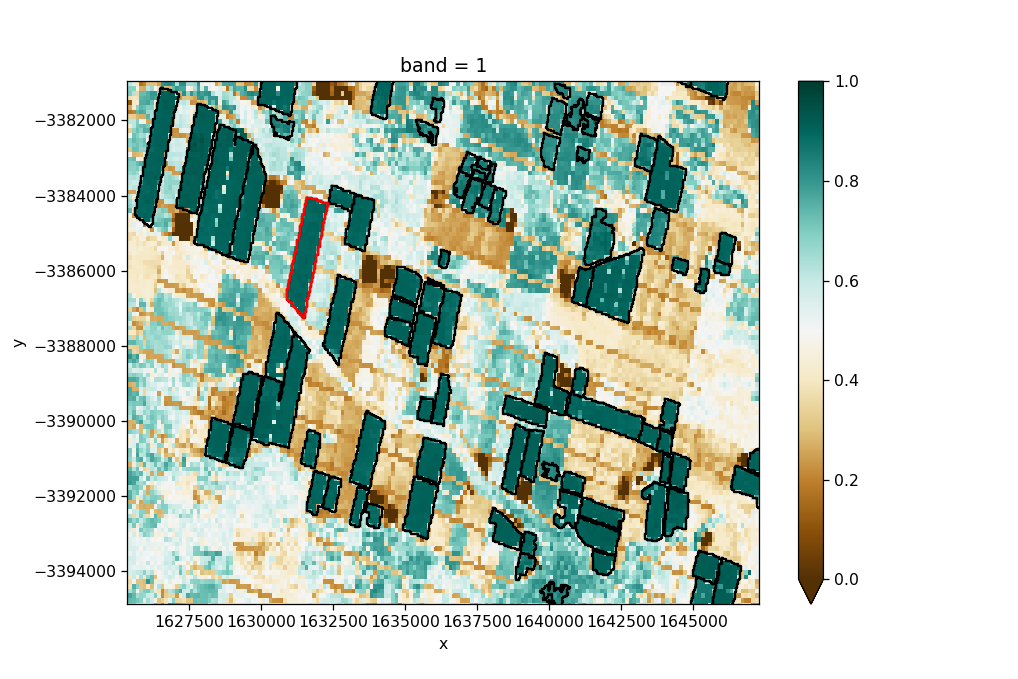

HTML(value='Click inside the polygon you would like to interrogate. \nNote that we are extracting and processi…

In [6]:
fig1 = plt.figure(figsize=[9, 6])

NDVIData.isel(x=range(0, len(NDVIData.x), 5),
              y=range(0, len(NDVIData.y), 5)).plot(cmap = 'BrBG', vmin=0, vmax = 1)

for shape in IrrigatedPolygons.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.show()

w = widgets.HTML("Click inside the polygon you would like to interrogate. \n"
                 "Note that we are extracting and processing data, so this step may take a few minutes to finish.")

cid = fig1.canvas.mpl_connect('button_press_event', onclick_polygon_interrogation)
display(w)

## Plot the field phenology using each observation over the growing season

<IPython.core.display.Javascript object>


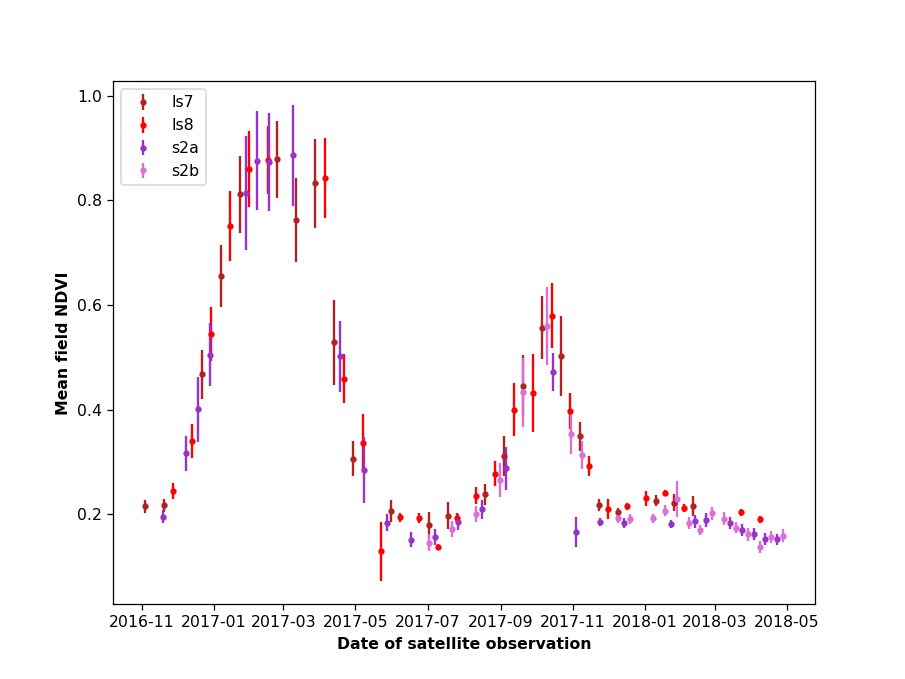

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Text(0.5, 0, 'Date of satellite observation')

In [7]:
fig = plt.figure(figsize = [8, 6])

# Generate a colorbar for Landsat and Sentinel. 
# Landsat will be plotted in shades of red, Sentinel in shades of purple.
NBARColours = {'ls5': 'darksalmon', 'ls7': 'firebrick', 'ls8':'red', 
               's2a':'darkorchid', 's2b':'orchid'}


if DataToInterrogate == 'nbar':
    for Sensor in AllSensors:
        try:
            plt.errorbar(AlldataMasked[Sensor].time.values, 
                        AlldataMasked[Sensor]['NDVI'].mean(dim = ('x', 'y')).values, 
                        yerr = AlldataMasked[Sensor]['NDVI'].std(dim = ('x', 'y')).values,
                        linestyle='none', marker='.', color = NBARColours[Sensor])
        except KeyError:
            pass
    plt.legend(AlldataMasked.keys(), loc = 'upper left')
    #plt.plot(FieldMean.time, FieldMean, 'lightgrey', linestyle = '--', zorder = 0)
    plt.ylabel('Mean field NDVI', fontweight = 'bold')
else:
    plt.plot(FieldMean.time, FieldMean.BS, 'ro-')
    plt.plot(FieldMean.time, FieldMean.PV, 'go-')
    plt.plot(FieldMean.time, FieldMean.NPV, 'ko-')
    for Sensor in AllSensors:
        try:
            plt.errorbar(AlldataMasked[Sensor].time.values, AlldataMasked[Sensor].BS.mean(dim = ('x', 'y')), 
                         yerr = AlldataMasked[Sensor].BS.std(dim = ('x', 'y')), 
                         color = 'red', linestyle='none', marker='.')
            plt.errorbar(AlldataMasked[Sensor].time.values, AlldataMasked[Sensor].PV.mean(dim = ('x', 'y')), 
                         yerr = AlldataMasked[Sensor].PV.std(dim = ('x', 'y')), 
                         color = 'green', linestyle='none', marker='.')
            plt.errorbar(AlldataMasked[Sensor].time.values, AlldataMasked[Sensor].NPV.mean(dim = ('x', 'y')), 
                         yerr = AlldataMasked[Sensor].NPV.std(dim = ('x', 'y')), 
                         color = 'black', linestyle='none', marker='.')
        except KeyError:
            pass
    plt.ylabel('Fractional Cover (%)', fontweight = 'bold')
    plt.legend(['Bare soil', 'Photosynthetic vegetation', 'Non-photosynthetic vegetation'], loc = 'upper left')
    
plt.xlabel('Date of satellite observation', fontweight = 'bold')